# Milestone Project: SkimLit

Build an NLP model to make reading medical abstracts easier.

## Confirm access to GPU

In [1]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Get data

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 1 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# Check what files are in the PubMeb_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
# Start our experiments using the 20K dataset with numbers replaced by "@" sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess data

We have some text data, and should visualize them.

Write a function to read in all of lines of a target text file.

In [6]:
# Create function to read lines of a document
def get_lines(filename):
  """
  Reads filenames (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [7]:
# Let's read in the trainingh lines
train_lines = get_lines(data_dir+"train.txt") # read the lines with the training file
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Let's think about how we want our data to look

How I think our data would be best represented

```
[{'line_number': 0,
    'target': "BACKGROUND',
    'text': 'xxx \n',
    'total_lines': }, 
    ...]
```

In [8]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts through each line,
  extracting things like the target label, text of the sentence, how many
  sentences are in the current abstract and what sentence number the target
  line is.
  """

  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # Create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith('###'): # check to see if the id line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract 

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # What number line does the line appear in line abstract
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many lines are there in the target abstract? (start with 0)
        abstract_samples.append(line_data) # add line data to abstract sample list

    else: # if the above condistions are not fullfilled, the line contains a labeled sentence
      abstract_lines += line
  return abstract_samples


In [9]:
# Get data from file and preprocess it 
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 562 ms, sys: 116 ms, total: 678 ms
Wall time: 681 ms


In [10]:
# Check the first abstract of our training data
train_samples[:10]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

Now data is a list of dictionaries, then change to DataFrame to visualize it

In [11]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples) 

In [12]:
# Distribution of lables in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

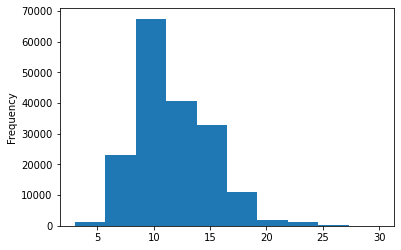

In [13]:
# Check the length of different lines
train_df.total_lines.plot.hist()

### Get lists of sentences

In [14]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

In [15]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

### One-Hot encoded labels

In [16]:
# One hot encode labels 
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # we want non-sparse matirx for tensorflow
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

# Check what our one-hot encoder looks like
train_labels_one_hot


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [17]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [18]:
# Get class names and number of clasess from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments

## Model 0: Getting a baseline

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [20]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [21]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Download helper functions scipt

In [22]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-04-01 14:17:18--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-04-01 14:17:18 (77.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [23]:
from helper_functions import *

In [24]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Preparing our data (the text) for deep sequence models

Create vectorization and embedding layers before deep learning models

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [26]:
# How long is each sentence on avaerage?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

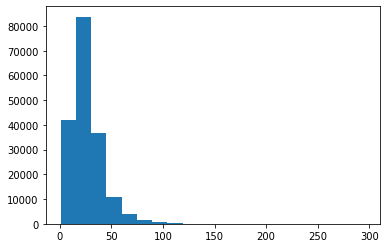

In [27]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [28]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [29]:
# Maximum sequence length in the training set
max(sent_lens)

296

### Create text vectorizer layer

Make a layer which maps our text to numbers

In [30]:
max_features = 68000 # Taken from the paper
max_len = 55

text_vectorizer = tf.keras.layers.TextVectorization(
 max_tokens=max_features,
 output_mode='int',
 output_sequence_length=max_len)

In [31]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [32]:
# Test out text vectorizer on random sentences 
import random 
target_sentence = random.choice(train_sentences)
print(target_sentence)
print(len(target_sentence.split())-1)
print(text_vectorizer([target_sentence]))

sixty postmenopausal women consumed butter during the stabilization period and were randomly divided into two groups for the intervention period : the treatment group of @ participants received dietary argan oil , the control group of @ participants received olive oil , and both groups applied cosmetic argan oil in the left volar forearm during a @-day period .
58
tf.Tensor(
[[ 1471  1460    90  1572 11277    52     2  4464   173     3     9    92
    471   143    51    24    11     2    38   173     2    19    13     4
     60    80   566 21188  1237     2    35    13     4    60    80  3746
   1237     3    54    24   551  3224 21188  1237     5     2   601  5310
   3664    52     8   108   173     0     0]], shape=(1, 55), dtype=int64)


In [33]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(len(rct_20k_text_vocab))
print(rct_20k_text_vocab[:5])

64841
['', '[UNK]', 'the', 'and', 'of']


In [34]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

### Create custom text Embedding

In [35]:
# Create token embedding layers
token_embed=layers.Embedding(
    input_dim = len(rct_20k_text_vocab),
    output_dim=128, # Different embedding sizes result in drastically different numbers of parameters to train
    mask_zero=True, # use masking to handle variable sequence lengths (save space)
    name="token_embedding"
)

In [36]:
# Show examgle embedding 
print(target_sentence)
vectorized_sentence = text_vectorizer([target_sentence])
print(vectorized_sentence)
embedded_sentence = token_embed(vectorized_sentence)
print(embedded_sentence)
print(embedded_sentence.shape)

sixty postmenopausal women consumed butter during the stabilization period and were randomly divided into two groups for the intervention period : the treatment group of @ participants received dietary argan oil , the control group of @ participants received olive oil , and both groups applied cosmetic argan oil in the left volar forearm during a @-day period .
tf.Tensor(
[[ 1471  1460    90  1572 11277    52     2  4464   173     3     9    92
    471   143    51    24    11     2    38   173     2    19    13     4
     60    80   566 21188  1237     2    35    13     4    60    80  3746
   1237     3    54    24   551  3224 21188  1237     5     2   601  5310
   3664    52     8   108   173     0     0]], shape=(1, 55), dtype=int64)
tf.Tensor(
[[[ 0.02972753 -0.00090595  0.0384406  ...  0.01906356 -0.01346297
    0.00428538]
  [-0.04192774 -0.00467606  0.0283682  ...  0.01954888 -0.04863248
    0.02570187]
  [-0.01376988  0.01521179  0.0494584  ...  0.01821003  0.04776039
   -0.0234

## Creating datasets (make sure our data loads as fast as possible)

* tf.data API

In [37]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,
                                                    train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,
                                                    val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,
                                                   test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [38]:
# Take the TensorSlice Dataset's and turn them into prefected dataset
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # AUTOTUNE represents as many as can 
valid_dataset= valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset= test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [39]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [40]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # Condense output of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])



In [41]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [42]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches                     

Epoch 1/3
562/562 [==============================] - 60s 105ms/step - loss: 0.9184 - accuracy: 0.6417 - val_loss: 0.6826 - val_accuracy: 0.7410
Epoch 2/3
562/562 [==============================] - 55s 99ms/step - loss: 0.6620 - accuracy: 0.7541 - val_loss: 0.6397 - val_accuracy: 0.7676
Epoch 3/3
562/562 [==============================] - 55s 99ms/step - loss: 0.6214 - accuracy: 0.7732 - val_loss: 0.5985 - val_accuracy: 0.7849


In [43]:
# Evaluate on whole valid dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.6009 - accuracy: 0.7850


[0.6009275317192078, 0.7850192189216614]

In [44]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.2661282e-01, 1.8783458e-01, 8.4207453e-02, 2.7361479e-01,
         2.7730366e-02],
        [4.3666610e-01, 2.9146957e-01, 1.2154649e-02, 2.5066945e-01,
         9.0402113e-03],
        [1.4789259e-01, 8.7235728e-03, 2.9031858e-03, 8.4044892e-01,
         3.1785170e-05],
        ...,
        [5.4290454e-06, 9.0871641e-04, 7.8089844e-04, 3.3156846e-06,
         9.9830163e-01],
        [6.0603753e-02, 5.0582975e-01, 8.5796170e-02, 7.9975612e-02,
         2.6779473e-01],
        [1.5975073e-01, 6.6635960e-01, 4.3127075e-02, 5.0683025e-02,
         8.0079511e-02]], dtype=float32), (30212, 5))

In [45]:
# Convet pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [46]:
# Calcualte model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.50191976698001,
 'f1': 0.78255592800629,
 'precision': 0.7817857160913774,
 'recall': 0.7850191976698001}

## Model 2: Feature extraction with pretrained token embeddings

Universal sentence encoder

In [47]:
# Download pretrained tensorflow hub use
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [48]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(random_train_sentence)
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence]) # No need to vectorized here 
print(use_embedded_sentence[:1])
print(use_embedded_sentence.shape)

no significant difference was found for overall pa with an adjusted difference of -@ cpm ( @ % ci : -@ , @ ) or for school time activity with an adjusted difference of @ cpm ( @ % ci : -@ , @ ) .
tf.Tensor(
[[-6.00540414e-02 -7.28885755e-02 -2.02430952e-02 -3.45089287e-02
  -3.39971446e-02  6.93770796e-02  1.04649141e-02 -1.07772192e-02
   5.70622720e-02  7.57813230e-02 -1.60350360e-03  4.39571403e-02
  -6.25299737e-02  7.04837888e-02  5.78177199e-02  3.89038026e-03
  -4.81301360e-02 -9.55128390e-03  6.58906577e-03 -2.84405928e-02
   5.93407229e-02  3.74579318e-02 -4.77795191e-02  5.55635877e-02
   1.15634240e-02  3.85348569e-03 -5.43687232e-02  5.82684316e-02
  -6.08450808e-02  2.30053512e-04 -3.61815691e-02 -2.63261832e-02
   9.64026246e-03  4.13006470e-02 -9.54897050e-03  5.56712272e-03
  -1.95618775e-02 -6.34231195e-02 -1.98685913e-03  3.32704633e-02
   2.59590819e-02  5.53965531e-02  2.05091183e-05  3.33279781e-02
   1.89348720e-02  3.17963921e-02  1.93186551e-02 -1.03917308e-02
 

## Building and fitting NLP feature extraction model using pretrained embeddings Tensorflow hub

In [49]:
# Define feature extraction model using TF Hub Layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) #tokenize text and create embedding of each sequence (512 vector long)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
# Note: Add more layers here if needed
outputs=layers.Dense(5, activation="softmax")(x) # Create the output
model_2 = tf.keras.Model(inputs=inputs, outputs=outputs, name="model_2_USE_feature_extractor")

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [50]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [51]:
# Fit model_2 to the data
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 10s 14ms/step - loss: 0.9209 - accuracy: 0.6454 - val_loss: 0.7982 - val_accuracy: 0.6878
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7679 - accuracy: 0.7012 - val_loss: 0.7534 - val_accuracy: 0.7041
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7511 - accuracy: 0.7121 - val_loss: 0.7368 - val_accuracy: 0.7161


In [52]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 10ms/step - loss: 0.7389 - accuracy: 0.7146


[0.7389116883277893, 0.7146497964859009]

In [53]:
# Make predictions with feature extraction mode
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[4.0387139e-01, 3.7913337e-01, 2.0899884e-03, 2.0706184e-01,
        7.8433957e-03],
       [3.7700862e-01, 4.5380828e-01, 3.0958457e-03, 1.6376866e-01,
        2.3186337e-03],
       [2.1688850e-01, 1.3067724e-01, 1.8256081e-02, 5.9695303e-01,
        3.7225101e-02],
       ...,
       [1.8600258e-03, 6.5064640e-03, 5.1221516e-02, 7.9035485e-04,
        9.3962157e-01],
       [3.6273042e-03, 4.8565805e-02, 1.9108085e-01, 1.3946299e-03,
        7.5533140e-01],
       [1.5317312e-01, 2.4886562e-01, 5.2922386e-01, 7.1873367e-03,
        6.1550144e-02]], dtype=float32)

In [54]:
# Convert the prediction probabilites found with feature extraction model to label 
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [55]:
# Calculate results from TF Hub pretrained embeddings results on the validation dataset
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.4649808023302,
 'f1': 0.7114585114731669,
 'precision': 0.7146406522828269,
 'recall': 0.714649808023302}

## Model 3: Conv1D with character embeddings

Combination of token and character embeddings

### Creating a character-level tokenizer

In [56]:
# Make function to split sentences into charactrers
def split_chars(text):
  return " ".join(list(text)) 

In [57]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [58]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

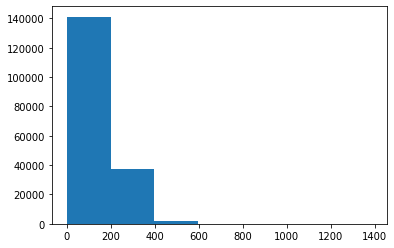

In [59]:
# Check the distribution of our sequences at a character-level 
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [60]:
# Find what character length covers 95% of sequence
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [61]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [62]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # Add 2 for space and OOV token (OOV = out of vocab)
char_vectorizer = tf.keras.layers.TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    name="char_vectorizer")

In [63]:
## Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [64]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(char_vocab[:5])
print(len(char_vocab))
print(char_vocab[-5:])

['', '[UNK]', 'e', 't', 'i']
28
['k', 'x', 'z', 'q', 'j']


In [65]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(random_train_chars)
print(len(random_train_chars))
vectorized_char = char_vectorizer([random_train_chars])
print(vectorized_char) 

a n   o v e r a l l   r i s k   s c o r e   w a s   u s e d   a s   o u t c o m e   m e a s u r e   ,   t h e n   e f f e c t s   o n   t h e   @   i n d i v i d u a l   l i f e s t y l e   b e h a v i o r s   w e r e   a s s e s s e d   a n d   a   p r o c e s s   e v a l u a t i o n   w a s   p e r f o r m e d   r e g a r d i n g   e x p o s u r e   t o   a n d   a p p r e c i a t i o n   o f   t h e   i n t e r v e n t i o n   .
435
tf.Tensor(
[[ 5  6  7 21  2  8  5 12 12  8  4  9 23  9 11  7  8  2 20  5  9 16  9  2
  10  5  9  7 16  3 11  7 15  2 15  2  5  9 16  8  2  3 13  2  6  2 17 17
   2 11  3  9  7  6  3 13  2  4  6 10  4 21  4 10 16  5 12 12  4 17  2  9
   3 19 12  2 22  2 13  5 21  4  7  8  9 20  2  8  2  5  9  9  2  9  9  2
  10  5  6 10  5 14  8  7 11  2  9  9  2 21  5 12 16  5  3  4  7  6 20  5
   9 14  2  8 17  7  8 15  2 10  8  2 18  5  8 10  4  6 18  2 24 14  7  9
  16  8  2  3  7  5  6 10  5 14 14  8  2 11  4  5  3  4  7  6  7 17  3 13
   2  4  6  3  2  8 21  2  6  3

### Creating a character-level embedding

In [66]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab), # number of different characters
                              output_dim=25, # this is the size of char embedding from the paper figure 1
                              mask_zero=True,
                              name="char_embed")

In [67]:
# Test out character embedding layer
print(char_embed(char_vectorizer([random_train_chars])))
print(char_embed(char_vectorizer([random_train_chars])).shape)

tf.Tensor(
[[[ 0.04732469  0.02863761 -0.04247513 ...  0.02236703  0.02485318
    0.00310297]
  [ 0.01637092  0.01270202 -0.02061691 ...  0.02217928 -0.04182319
   -0.01173253]
  [-0.00333672 -0.01749886  0.01031924 ...  0.04518167  0.00505639
   -0.00239837]
  ...
  [-0.0288153  -0.04625154 -0.0183556  ... -0.02506292 -0.04746575
   -0.03024693]
  [-0.0288153  -0.04625154 -0.0183556  ... -0.02506292 -0.04746575
   -0.03024693]
  [-0.0288153  -0.04625154 -0.0183556  ... -0.02506292 -0.04746575
   -0.03024693]]], shape=(1, 290, 25), dtype=float32)
(1, 290, 25)


### Build a conv1D to fit on character embedding

In [68]:
# Create 1D conv model on chars only
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs) # vectorize text inputs
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalAveragePooling1D()(x) # Condense output of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs)

# Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [69]:
model_3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_3 (Dense)             (None, 5)                 325 

In [70]:
# Create char level datasets
train_char_dataset =tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset =tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset =tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)


In [71]:
# Fit the model on chars only
history_model_3 = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset))) # only validate on 10% of batches                     

Epoch 1/3
562/562 [==============================] - 12s 19ms/step - loss: 1.4569 - accuracy: 0.3551 - val_loss: 1.3970 - val_accuracy: 0.4092
Epoch 2/3
562/562 [==============================] - 11s 19ms/step - loss: 1.3628 - accuracy: 0.4245 - val_loss: 1.3333 - val_accuracy: 0.4415
Epoch 3/3
562/562 [==============================] - 11s 19ms/step - loss: 1.3249 - accuracy: 0.4493 - val_loss: 1.3182 - val_accuracy: 0.4392


In [72]:
# Make predictions (our model predicts prediction probabilities for each class)
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs, model_3_pred_probs.shape

# Convet pred probs to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

# Calcualte model_1 results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 44.42274592877003,
 'f1': 0.38762670598702065,
 'precision': 0.37504674850447794,
 'recall': 0.44422745928770024}

## Model 4: Combining pretrained token embedding + characters (hybrid embeeding)

1. Create a token-level embedding model (similar `model_1`)
2. Create a character-level model (similar to `model_3` with slight modification)
3. Combine 1 & 2 with a concatenate (`layers.Concatnate`).
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 in the paper.
5. Construct a model which takes token and character level sequences as input and produces sequence label probabilites as output. 

In [73]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM show in figure 1 in the paper
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybird")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - adding in Dropout (0.5)
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [74]:
# Get a summary of our model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

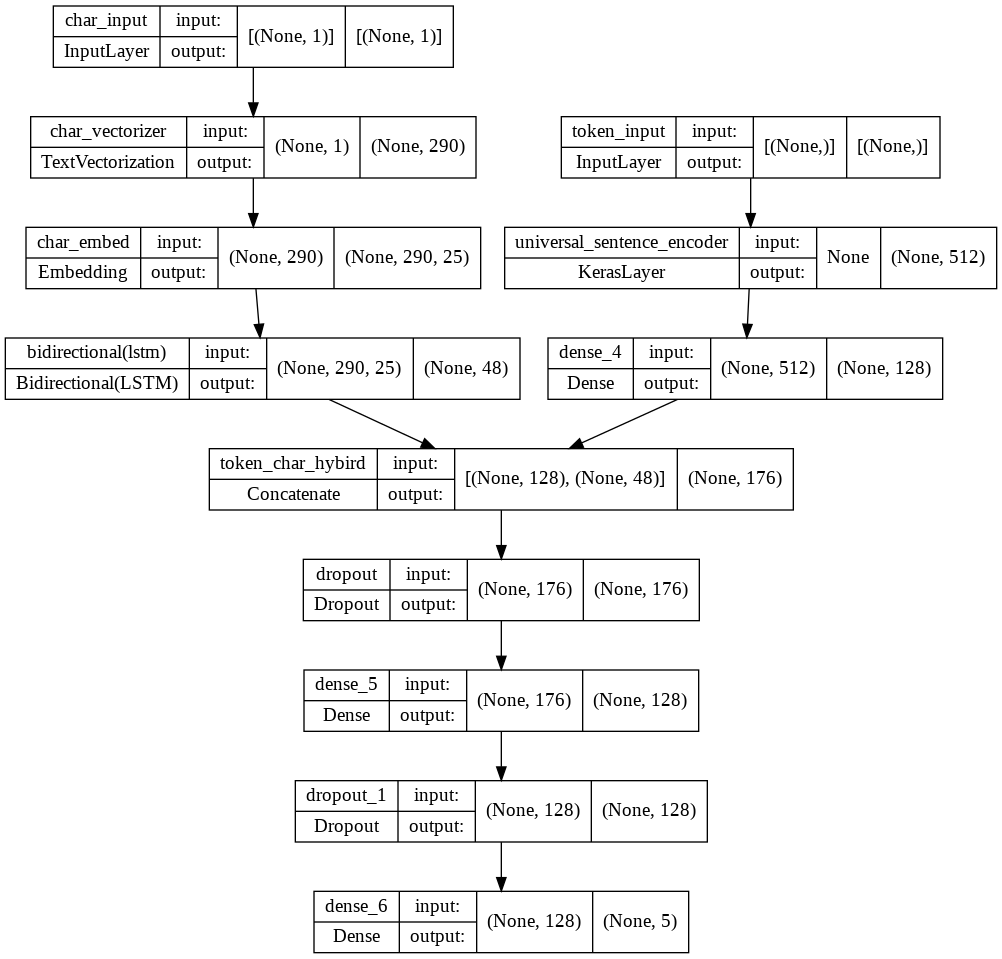

In [77]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [78]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Combining token and character data into a tf.data Dataset

In [82]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

# prefetech and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [83]:
# Repeat above fopr our validation data
# Combine chars and tokens into a dataset
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

# prefetech and batch train data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [84]:
# Check out our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences

In [87]:
# Fit the model 
history_mdeol_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 184s 311ms/step - loss: 0.9910 - accuracy: 0.6004 - val_loss: 0.7959 - val_accuracy: 0.6995
Epoch 2/3
562/562 [==============================] - 156s 278ms/step - loss: 0.8148 - accuracy: 0.6824 - val_loss: 0.7254 - val_accuracy: 0.7227
Epoch 3/3
562/562 [==============================] - 157s 279ms/step - loss: 0.7847 - accuracy: 0.6995 - val_loss: 0.7002 - val_accuracy: 0.7380


In [88]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 53s 56ms/step - loss: 0.7048 - accuracy: 0.7295


[0.7047801613807678, 0.7295114398002625]

In [89]:
# Make predictions using the token_character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[4.2171007e-01, 3.7886295e-01, 3.3059532e-03, 1.9012617e-01,
        5.9948433e-03],
       [3.0608577e-01, 4.8057899e-01, 2.0008271e-03, 2.1032426e-01,
        1.0101163e-03],
       [2.6354751e-01, 1.6641346e-01, 4.5008358e-02, 5.0178283e-01,
        2.3247812e-02],
       ...,
       [7.3419587e-04, 8.1327772e-03, 8.6940944e-02, 2.9325840e-04,
        9.0389884e-01],
       [5.8554858e-03, 5.0762840e-02, 2.4462254e-01, 2.9849510e-03,
        6.9577414e-01],
       [2.1367939e-01, 4.6395987e-01, 2.4339591e-01, 1.9956265e-02,
        5.9008606e-02]], dtype=float32)

In [90]:
# Format pre probs into prd labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [91]:
# get results of token char hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)

In [92]:
model_4_results

{'accuracy': 72.95114524030186,
 'f1': 0.7260275805908427,
 'precision': 0.7322788671407523,
 'recall': 0.7295114524030186}

## Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

* Note: Any enginerred features used to train on the model need to be available on the test time. In our case, line numbers and total lines are available

### Create positional embeddings

In [93]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

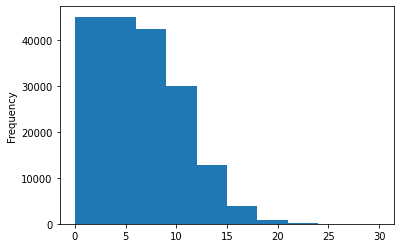

In [95]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist();

In [106]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [98]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

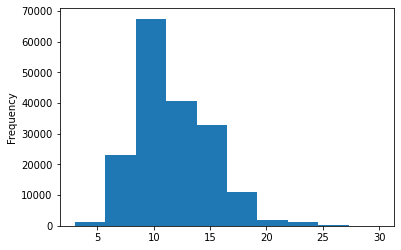

In [100]:
# Check the distributions of total lines
train_df.total_lines.plot.hist();

In [102]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [105]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

### Building a tribrid 

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs o f 3 & 4 & 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribried embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a tf.keras.Model

In [140]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                total_lines_model.output,
                                                                                z]) 

# 7. Create output layer
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

In [137]:
# Get a summary of tribrid embedding model
model_5.summary()

Model: "model_37"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']    

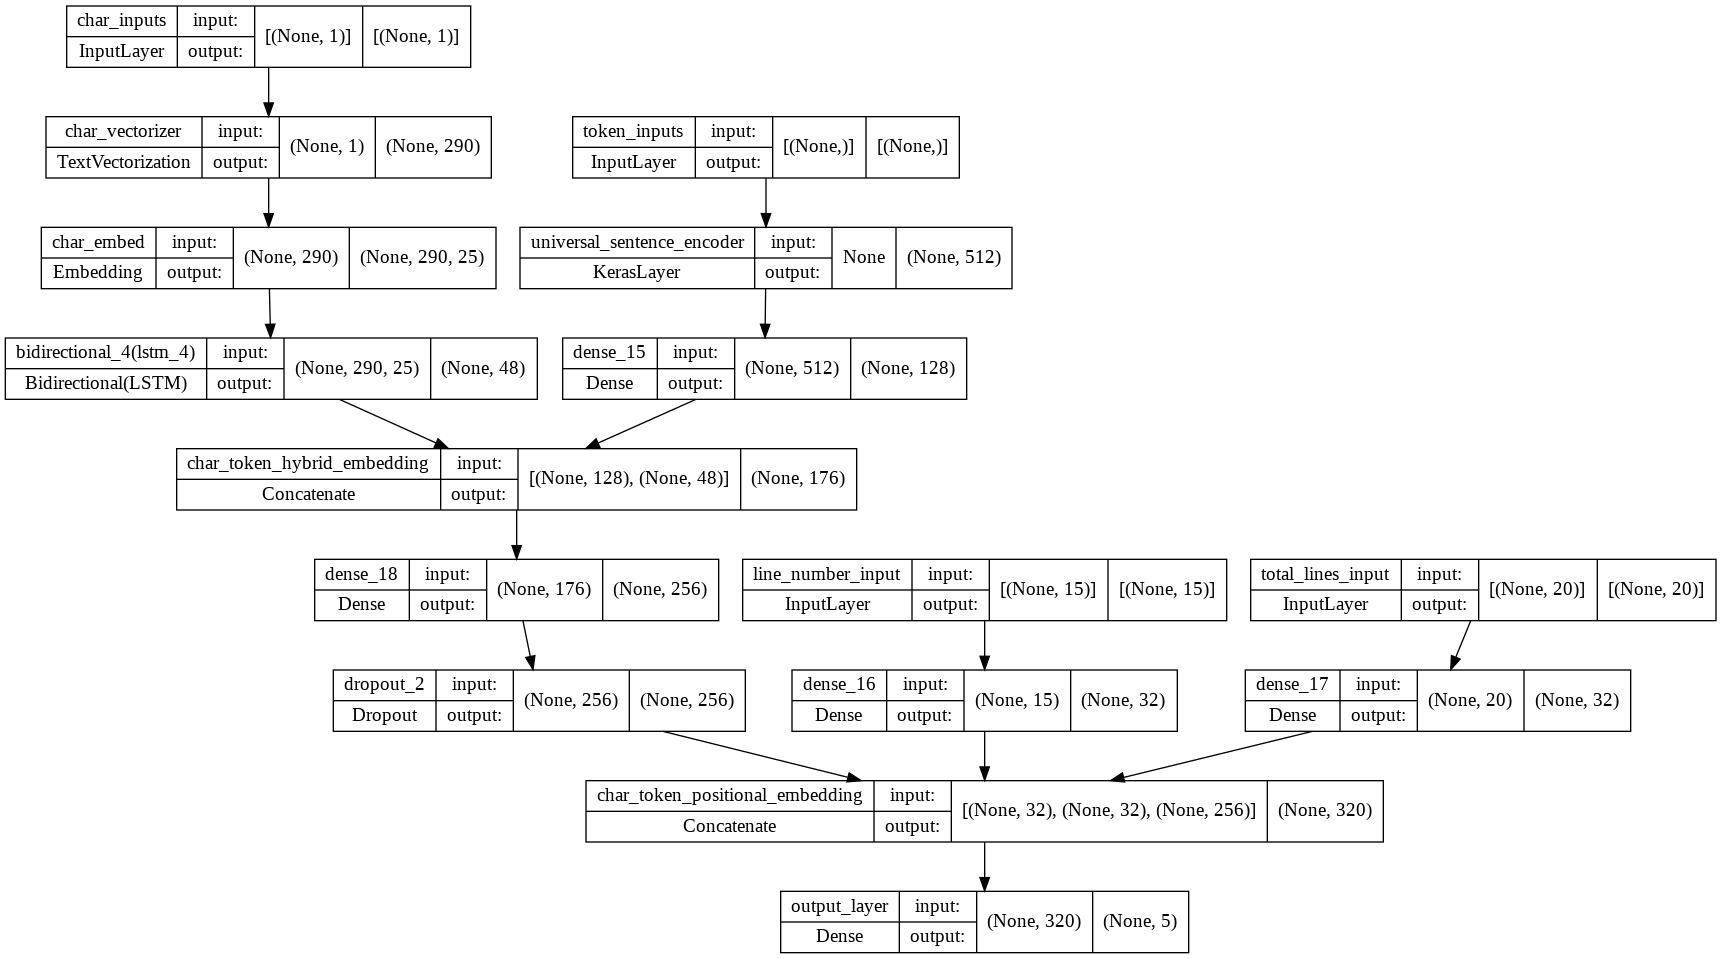

In [114]:
# Plot model 5
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

Label smoothing

If our model gets too confident on a single calss, it may get stuck on that class and not consider other classes. What label smoothing does is it assigns some of the value from the highest prediction probabilites to other classes, in turn, hopefully improving generalization.

In [142]:
# Compile the model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # help to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


### Create tribrid embedding datasets using tf.data

In [141]:
# Create training and validation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                              train_total_lines_one_hot,
                                                              train_sentences,
                                                              train_chars))


train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels)) 
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above for validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))


val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels)) 
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [120]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(15,), dtype=tf.float32, name=None), TensorSpec(shape=(20,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None)), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(15,), dtype=tf.float32, name=None), TensorSpec(shape=(20,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None)), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>)

### Fitting, evaluate and make predictions

In [143]:
# Fit the model 
history_mdeol_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 194s 329ms/step - loss: 1.0937 - accuracy: 0.7209 - val_loss: 0.9848 - val_accuracy: 0.8059
Epoch 2/3
562/562 [==============================] - 160s 284ms/step - loss: 0.9669 - accuracy: 0.8159 - val_loss: 0.9507 - val_accuracy: 0.8248
Epoch 3/3
562/562 [==============================] - 163s 290ms/step - loss: 0.9499 - accuracy: 0.8228 - val_loss: 0.9373 - val_accuracy: 0.8338


In [146]:
# make predictions with the char token pos model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 74s 75ms/step


array([[0.50459486, 0.11536641, 0.01164727, 0.35207522, 0.01631627],
       [0.5219076 , 0.09366676, 0.04582951, 0.3281724 , 0.01042358],
       [0.29850414, 0.11822664, 0.14809774, 0.36566556, 0.06950584],
       ...,
       [0.03320498, 0.11863634, 0.03865127, 0.03135706, 0.7781504 ],
       [0.03058549, 0.33607623, 0.07656206, 0.02386878, 0.5329074 ],
       [0.24408643, 0.5623124 , 0.08735665, 0.04053567, 0.06570891]],
      dtype=float32)

In [147]:
# Convert pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [148]:
# Calculate resutls 
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred =model_5_preds)

## Comapre model results

In [153]:
# Combine model results into a datafrtame
all_model_results = pd.DataFrame({
    "model_0_baseline": baseline_results,
    "model_1_custom_token_embedding": model_1_results,
    "model_2_pretrained_token_embedding": model_2_results,
    "model_3_customer_char_embedding": model_3_results,
    "model_4_hybrid_char_token_embedding": model_4_results,
    "model_5_pos_char_token_embedding": model_5_results
})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.501920,0.781786,0.785019,0.782556
model_2_pretrained_token_embedding,71.464981,0.714641,0.714650,0.711459
model_3_customer_char_embedding,44.422746,0.375047,0.444227,0.387627
model_4_hybrid_char_token_embedding,72.951145,0.732279,0.729511,0.726028
model_5_pos_char_token_embedding,83.437045,0.833093,0.834370,0.833319


In [154]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

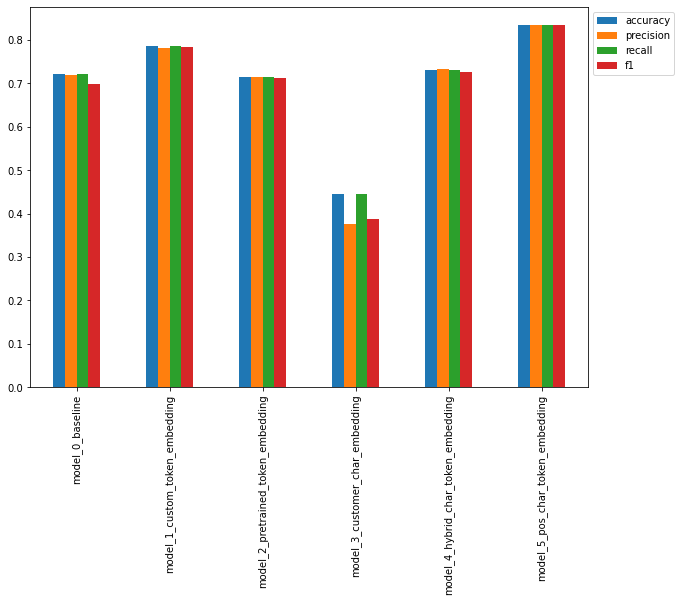

In [156]:
# Plot and compare all model results
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0));

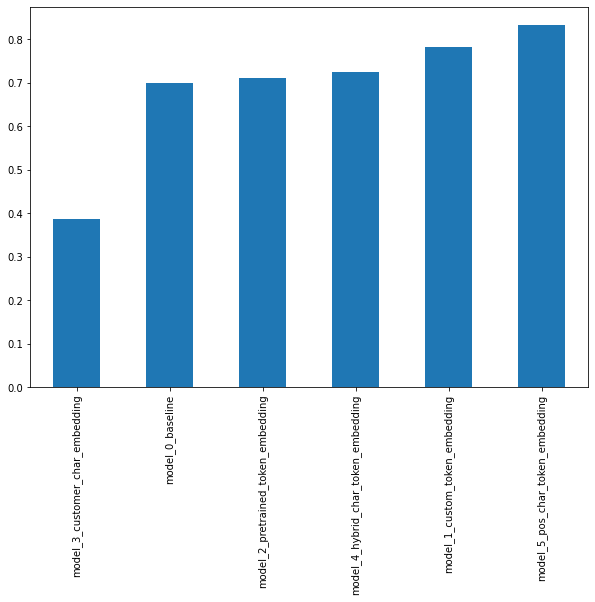

In [158]:
# Sor models by f1 score
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10,7));